In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from inexact_psgla import *
from psgla import *
from pxmala import *
import distributions as pds
import potentials as pot

**Generate data for the likelihood function**

In [41]:
mu_true = 0.8
sigma2_true = 0.5
n_data = 1
nu = 4
rng = default_rng(34523)
D = rng.normal(loc=mu_true,scale=np.sqrt(sigma2_true),size=(n_data,))

**Define the posterior distribution**\
The prior is assumed to be a Gamma distribution with shape parameter $\alpha = \frac{\nu}{2}$, the likelihood is mean estimation for the data points $D_i$.\
Require $\nu > 2$ since we want a log-concave distribution.

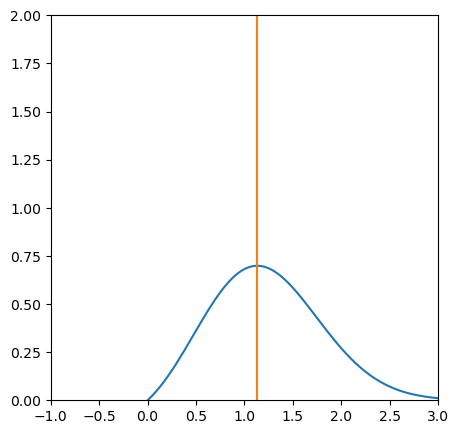

In [42]:
posterior = pds.Gamma_Gauss1D_Posterior_Salim21(data=D, scale=np.sqrt(sigma2_true), nu=nu)
# metaparameter of the distribution: L = Lipschitz constant of nabla F
L = np.linalg.norm(posterior.F.K)**2 / sigma2_true
t = np.reshape(np.linspace(1e-4, 5*nu+np.mean(D),500),(1,-1))
dens_vals = posterior.pdf(t)

plt.figure(figsize=(5,5))
unscaled_dens_plot = plt.plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)))
xlims = plt.xlim(-1, 3.0)
ylims = plt.ylim(0,2)
mu_map = sigma2_true/(2*n_data)*(n_data/sigma2_true*np.mean(D)-1/2 + np.sqrt((1/2-n_data/sigma2_true*np.mean(D))**2 - 4*n_data/sigma2_true*(1-nu/2)))
plt.plot([mu_map, mu_map],[0,2])
plt.show()

**Sample once using Px-MALA to have an unbiased estimate of the target for the Wasserstein estimates**

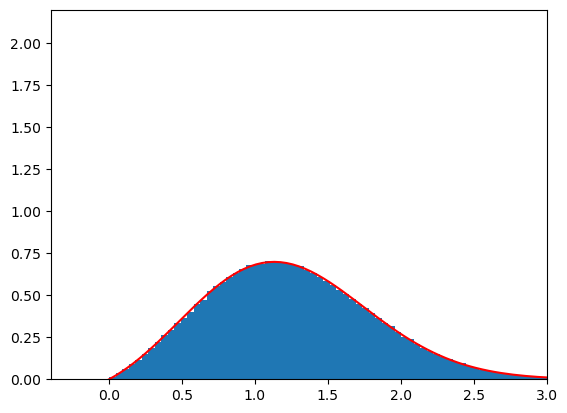

In [43]:
# one run of Px-MALA for Wasserstein comparison
tau_pxmala = 0.9/L
max_iter_pxmala = 1000
n_samples_pxmala = 1000
# initialize at the MAP to minimize burn-in time
x0_pxmala = mu_map*np.ones((1,n_samples_pxmala))
pxmala = PxMALA(max_iter_pxmala, tau_pxmala, x0_pxmala, pd = posterior)

x_pxmala = pxmala.simulate(return_all=True)
x_pxmala_hist = np.reshape(x_pxmala[:,:,100:1000], (-1,))
plt.hist(x_pxmala_hist,100,density=True);
plt.plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf');
plt.xlim(-0.4, 3);  plt.ylim(0,2.2);

**Sample using PSGLA and inexact PSGLA**

In [49]:
# same parameters for both samplers
tau = 0.9/L
max_iter = int(np.max((50,np.round(0.3/tau))))
n_samples = 1000
x0 = 10*np.ones((1,n_samples)) #np.mean(D)*np.ones((1,n_samples))

# psgla
pla = PSGLA(max_iter, tau, x0, pd = posterior)
x_pla, W2dist_pla = pla.simulate(x_comp = x_pxmala[:,:,100:1000],return_all=True)

# inexact prox psgla
epsilon = 0.1
ipla = IPSGLA(max_iter, tau, x0, epsilon, pd=posterior)
x_ipla, W2dist_ipla = ipla.simulate(x_comp = x_pxmala[:,:,100:1000],return_all=True)

**Compare samples**

In [50]:
# histograms of samples
x_pxmala_hist = np.reshape(x_pxmala[:,:,100:1000], (-1,))
x_pla_hist = np.reshape(x_pla, (n_samples,1,max_iter+1))
x_ipla_hist = np.reshape(x_ipla, (n_samples,1,max_iter+1))

def hist_iterates(k=max_iter):
    fig, ax = plt.subplots(1, 3, figsize=(25,5))
    ax[0].set_xlim(-0.4, 3);  ax[0].set_ylim(0,2.2);
    
    pdf_plot_pxmala = ax[0].plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    ax[0].set_title('Px-MALA (unbiased sampling)');
    pdf_plot_psgla = ax[1].plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    ax[1].set_title('PLA');
    pdf_plot_myula = ax[2].plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    ax[2].set_title('inexact PLA, errors = {:.3e}'.format(epsilon));

    hist_gt = ax[0].hist(x_pxmala_hist, 100, density=True);
    hist_pla = ax[1].hist(x_pla_hist[:,:,k], 100, density=True);
    ax[1].set_xlim(-0.4, 3);  ax[1].set_ylim(0,2.2);
    hist_ipla = ax[2].hist(x_ipla_hist[:,:,k], 100, density=True);
    ax[2].set_xlim(-0.4, 3);  ax[2].set_ylim(0,2.2);
interact(hist_iterates, k=(0,max_iter))
#hist_iterates()

interactive(children=(IntSlider(value=50, description='k', max=50), Output()), _dom_classes=('widget-interact'…

<function __main__.hist_iterates(k=50)>

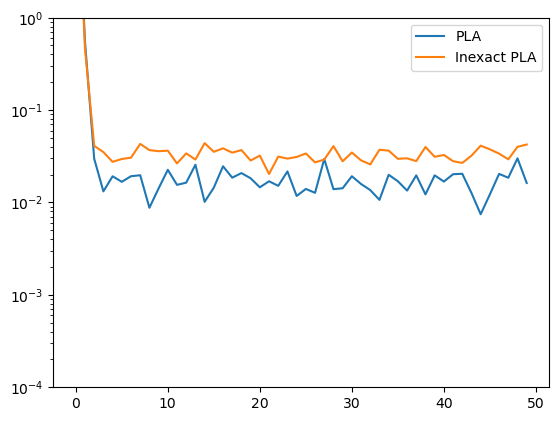

In [51]:
plt.semilogy(W2dist_pla[0:max_iter], label='PLA')
plt.semilogy(W2dist_ipla[0:max_iter], label='Inexact PLA')
plt.legend()
plt.ylim(1e-4,1e0);

In [52]:
lambdaF = L
print('Predicted maximum additional error due to prox inexactness: {:.2e}'.format(2*epsilon/lambdaF))

Predicted maximum additional error due to prox inexactness: 1.00e-01
